# Telecom X Customer Churn Analysis

## Objective
Analyze customer churn patterns to identify key factors influencing customer retention.

## Dataset Overview
- **Source**: TelecomX customer data
- **Size**: 7,267 customers with 22 features
- **Target**: Customer churn (binary classification)


1. Data extraction:

---



In [1]:
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

# URL of the raw JSON file
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"

# Load the JSON data directly into a pandas DataFrame
df = pd.read_json(url)

# Display the first rows of the DataFrame to verify the data
df.head()


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


2. Data manipulation

---



Quality Assessment





In [2]:
print("=== TELECOM X - DATA QUALITY ASSESSMENT ===\n")

# 1. BASIC DATASET INFORMATION
print("1. BASIC DATASET INFORMATION")
print("-" * 40)
print()
print(f"Dataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {list(df.columns)}")
print()

# 2. COMPREHENSIVE MISSING VALUES ANALYSIS
print("2. COMPREHENSIVE MISSING VALUES ANALYSIS")
print("-" * 40)
print()

# Check for traditional missing values
traditional_missing = df.isnull().sum()
print("Traditional missing values (NaN/None):")
for col in df.columns:
    if traditional_missing[col] > 0:
        print(f"  {col}: {traditional_missing[col]}")
if traditional_missing.sum() == 0:
    print("  ✅ No traditional missing values (NaN/None)")

# Check for other suspicious values using pandas.unique()
print("\nDetailed value analysis using pandas.unique():")

for col in ['Churn', 'customerID']:
    if col in df.columns:
        unique_vals = pd.unique(df[col])
        print(f"  {col} unique values: {unique_vals}")
        print(f"  {col} total unique count: {len(unique_vals)}")

        if col == 'Churn':
            print(f"  {col} value counts:")
            value_counts = df[col].value_counts(dropna=False)

            # Identify invalid values and total invalid record count
            valid_churn_values = ['Yes', 'No']
            invalid_churn = [(val, cnt) for val, cnt in value_counts.items() if val not in valid_churn_values]
            total_invalid = sum(cnt for _, cnt in invalid_churn)

            for val, cnt in value_counts.items():
                val_repr = repr(val)
                perc = cnt / len(df) * 100
                flag = " ⚠️ INVALID" if val not in valid_churn_values else ""
                print(f"    {val_repr}: {cnt} ({perc:.1f}%) {flag}")

            if total_invalid:
                print(f"    ⚠️  Found {total_invalid} total invalid Churn records (empty/other).")
                empty_values_found = True

        if pd.api.types.is_datetime64_any_dtype(df[col]):
            print(f"  {col} datetime analysis:")
            normalized = df[col].dt.normalize()
            ud = pd.unique(normalized.dropna())
            print(f"    Unique dates (normalized): {len(ud)}")
            print(f"    Date range: {ud.min()} to {ud.max()}")

print()

# 3. NESTED JSON COLUMNS ANALYSIS
print("3. NESTED JSON COLUMNS ANALYSIS")
print("-" * 40)
print()

json_cols = ['customer','phone','internet','account']
for col in json_cols:
    if col not in df:
        continue
    print(f"\n{col.upper()} column analysis:")
    sample = df[col].iloc[0]
    if not isinstance(sample, dict):
        print(f"  ❌ Not a dict: {type(sample)}")
        continue

    keys = list(sample.keys())
    print(f"  Expected keys: {keys}")

    for key in keys:
        # Handle Charges sub-dict separately
        if key == 'Charges':
            sub_keys = list(sample['Charges'].keys())
            for sk in sub_keys:
                vals = []
                for row in df[col]:
                    v = row.get('Charges', {}).get(sk)
                    if isinstance(v, (dict, list)):
                        v = json.dumps(v)
                    vals.append(v)
                s = pd.Series(vals)
                uv = pd.unique(s.dropna())
                uv_clean = [x.item() if isinstance(x, np.generic) else x for x in uv]
                print(f"    Charges.{sk}:")
                print(f"      Unique count: {len(uv_clean)}")
                print(f"      Sample: {uv_clean[:5]}")
                empty_cnt = (s=="").sum()
                null_cnt  = s.isnull().sum()
                if empty_cnt or null_cnt:
                    print(f"      ⚠️ Missing: {empty_cnt} empty, {null_cnt} null")
        else:
            vals = []
            for row in df[col]:
                v = row.get(key)
                if isinstance(v, (dict, list)):
                    v = json.dumps(v)
                vals.append(v)
            s = pd.Series(vals)
            uv = pd.unique(s.dropna())
            uv_clean = [x.item() if isinstance(x, np.generic) else x for x in uv]
            print(f"    {key}:")
            print(f"      Unique count: {len(uv_clean)}")
            print(f"      Sample: {uv_clean[:5]}")
            empty_cnt = (s=="").sum()
            null_cnt  = s.isnull().sum()
            if empty_cnt or null_cnt:
                print(f"      ⚠️ Missing: {empty_cnt} empty, {null_cnt} null")

print()

# 4. DUPLICATE RECORDS CHECK (ENHANCED)
print("4. DUPLICATE RECORDS CHECK")
print("-" * 40)
print()

# Check duplicates on customerID using pandas.unique() for better performance
unique_customer_ids = pd.unique(df['customerID'])
duplicate_customer_ids = len(df) - len(unique_customer_ids)
print(f"Duplicate customer IDs: {duplicate_customer_ids}")

# For total row duplicates, convert JSON columns to strings first
df_for_duplicate_check = df.copy()
json_columns = ['customer', 'phone', 'internet', 'account']

for col in json_columns:
    if col in df_for_duplicate_check.columns:
        df_for_duplicate_check[col] = df_for_duplicate_check[col].astype(str)

total_duplicates = df_for_duplicate_check.duplicated().sum()
print(f"Total duplicate rows: {total_duplicates}")

if total_duplicates > 0 or duplicate_customer_ids > 0:
    print("⚠️  Duplicate records found - needs investigation")
else:
    print("✅ No duplicate records found")

print()

# 5. DATA TYPE VALIDATION WITH ENHANCED ANALYSIS
print("5. DATA TYPE VALIDATION")
print("-" * 40)
print()

# Enhanced customerID validation using pandas.unique()
customer_ids = pd.unique(df['customerID'])
print(f"Total unique customer IDs: {len(customer_ids)}")

# Pattern validation
valid_pattern = pd.Series(customer_ids).str.match(r'^[0-9]{4}-[A-Z]{5}$')
invalid_count = (~valid_pattern).sum()

print(f"Invalid customerID format: {invalid_count}")
if invalid_count > 0:
    print("⚠️  Some customer IDs don't follow expected pattern (####-XXXXX)")
    invalid_ids = pd.Series(customer_ids)[~valid_pattern].head(5).tolist()
    print(f"  Examples of invalid IDs: {invalid_ids}")
else:
    print("✅ All customer IDs follow expected format")

# Check for potential date columns that might need dt.normalize()
print("\nDate/Time column detection:")
date_columns_found = False
for col in df.columns:
    if pd.api.types.is_datetime64_any_dtype(df[col]):
        date_columns_found = True
        print(f"  {col}: Datetime column detected")
        print(f"    Use df['{col}'].dt.normalize() to remove time component if needed")
        print(f"    Date range: {df[col].min()} to {df[col].max()}")

if not date_columns_found:
    print("  ℹ️  No datetime columns detected in current dataset")

print()

# 6. SUMMARY
print("6. SUMMARY")
print("-" * 40)
print()

issues_found = []
recommendations = []

# Check for issues
if traditional_missing.sum() > 0:
    issues_found.append("Traditional missing values detected")
if empty_values_found:  # This will be True if invalid Churn values exist
    issues_found.append("Empty strings, whitespace-only, or invalid categorical values found")
    recommendations.append("Handle empty/invalid values in Churn column before modeling")
    recommendations.append("Consider removing or imputing invalid Churn values")
if duplicate_customer_ids > 0:
    issues_found.append("Duplicate customer IDs found")
if total_duplicates > 0:
    issues_found.append("Duplicate rows found")
if invalid_count > 0:
    issues_found.append("Invalid customer ID formats")
    recommendations.append("Fix invalid customer ID formats")

# Results
if len(issues_found) == 0:
    print("✅ No major data quality issues detected!")
else:
    print("⚠️  Issues found that need attention:")
    for issue in issues_found:
        print(f"   • {issue}")

print("\nRecommendations:")
for rec in recommendations:
    print(f"   • {rec}")

recommendations.clear() # Garbage collection

=== TELECOM X - DATA QUALITY ASSESSMENT ===

1. BASIC DATASET INFORMATION
----------------------------------------

Dataset Shape: (7267, 6)
Rows: 7267
Columns: ['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']

2. COMPREHENSIVE MISSING VALUES ANALYSIS
----------------------------------------

Traditional missing values (NaN/None):
  ✅ No traditional missing values (NaN/None)

Detailed value analysis using pandas.unique():
  Churn unique values: ['No' 'Yes' '']
  Churn total unique count: 3
  Churn value counts:
    'No': 5174 (71.2%) 
    'Yes': 1869 (25.7%) 
    '': 224 (3.1%)  ⚠️ INVALID
    ⚠️  Found 224 total invalid Churn records (empty/other).
  customerID unique values: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
  customerID total unique count: 7267

3. NESTED JSON COLUMNS ANALYSIS
----------------------------------------


CUSTOMER column analysis:
  Expected keys: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 

Normalization and error handling

In [3]:
# 1. Normalize and impute Churn blanks as "yes"
df['Churn'] = (
    df['Churn']
    .fillna('Yes')                            # NaN → "yes"
    .astype(str)
    .str.strip()                             # remove surrounding whitespace
    .str.lower()                             # all lowercase
    .replace({'': 'Yes'})                     # blank → "yes"
)

# 2. Flatten nested JSON
cust = pd.json_normalize(df.pop('customer'))
phone = pd.json_normalize(df.pop('phone'))
inet = pd.json_normalize(df.pop('internet'))
acct = pd.json_normalize(df.pop('account'))

df = pd.concat([df, cust, phone, inet, acct], axis=1)

# 3. Convert numeric fields
df['tenure']          = df['tenure'].astype(int)
df['Charges.Monthly'] = df['Charges.Monthly'].astype(float)
df['Charges.Total']   = df['Charges.Total'].replace(r'^\s*$', np.nan, regex=True).astype(float)

# 4. Convert categorical columns for memory efficiency, preserving all values
categorical_cols = [
    'gender', 'Contract', 'PaymentMethod', 'InternetService',
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

for col in categorical_cols:
    df[col] = df[col].astype('category')

# 5. Normalize and convert all Yes/No columns to bool
import re
yesno = re.compile(r'^\s*(yes|no)\s*$', re.IGNORECASE)
for col in df.select_dtypes('object').columns:
    vals = df[col].dropna().astype(str)
    if vals.str.match(yesno).all():
        df[col] = (
            df[col]
            .fillna('no')
            .astype(str)
            .str.strip()
            .str.lower()
            .map({'yes': True, 'no': False})
        )

Daily charge estimate

In [4]:
# 1. Compute daily charge estimate
df['Charges.Daily'] = df['Charges.Monthly'] / 30

# Quick check
print(df.info())
print(df[['customerID','Churn','PhoneService','Charges.Daily']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7267 non-null   object  
 1   Churn             7267 non-null   bool    
 2   gender            7267 non-null   category
 3   SeniorCitizen     7267 non-null   int64   
 4   Partner           7267 non-null   bool    
 5   Dependents        7267 non-null   bool    
 6   tenure            7267 non-null   int64   
 7   PhoneService      7267 non-null   bool    
 8   MultipleLines     7267 non-null   category
 9   InternetService   7267 non-null   category
 10  OnlineSecurity    7267 non-null   category
 11  OnlineBackup      7267 non-null   category
 12  DeviceProtection  7267 non-null   category
 13  TechSupport       7267 non-null   category
 14  StreamingTV       7267 non-null   category
 15  StreamingMovies   7267 non-null   category
 16  Contract          7267 n

3. Load and Analysis

---



Descriptive Analysis

=== Numeric Feature Summary ===
         tenure  Charges.Monthly  Charges.Total  Charges.Daily
count   7267.00          7267.00        7256.00        7267.00
mean      32.35            64.72        2280.63           2.16
median    29.00            70.30        1391.00           2.34
std       24.57            30.13        2268.63           1.00
min        0.00            18.25          18.80           0.61
25%        9.00            35.42         400.22           1.18
50%       29.00            70.30        1391.00           2.34
75%       55.00            89.88        3785.30           3.00
max       72.00           118.75        8684.80           3.96

=== Categorical Feature Distributions ===

-- Churn --
       Count  Percent
Churn                
False   5174     71.2
True    2093     28.8

-- gender --
        Count  Percent
gender                
Male     3675     50.6
Female   3592     49.4

-- Partner --
         Count  Percent
Partner                
False     3749     51.6
T

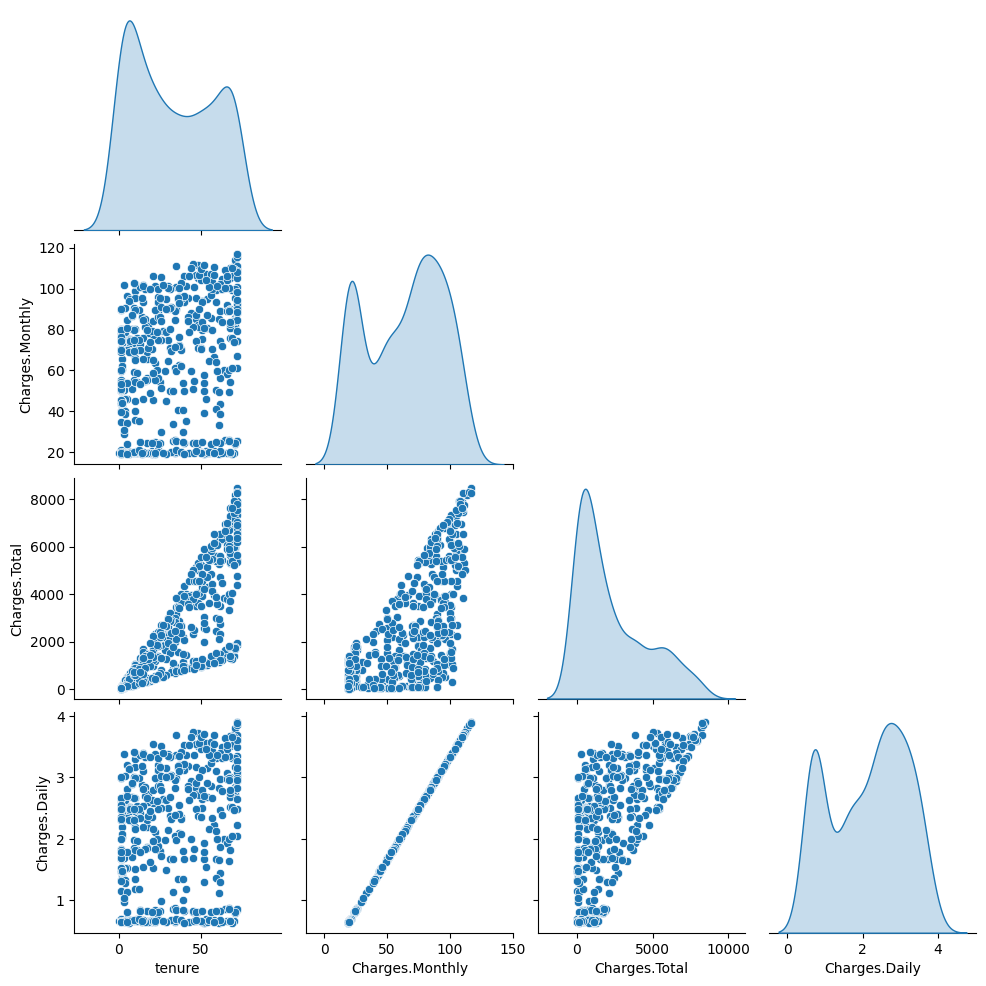

In [5]:
# 1. Descriptive statistics for numeric columns
numeric_cols = ['tenure', 'Charges.Monthly', 'Charges.Total', 'Charges.Daily']
desc_num = df[numeric_cols].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'quantile'])
# Add quartiles explicitly
desc_num.loc['25%'] = df[numeric_cols].quantile(0.25)
desc_num.loc['50%'] = df[numeric_cols].quantile(0.50)
desc_num.loc['75%'] = df[numeric_cols].quantile(0.75)
desc_num = desc_num.loc[['count','mean','median','std','min','25%','50%','75%','max']]
print("=== Numeric Feature Summary ===")
print(desc_num.round(2))


# 2. Value counts for categorical features
categorical_cols = [
    'Churn','gender','Partner','Dependents',
    'PhoneService','MultipleLines','InternetService',
    'OnlineSecurity','OnlineBackup','DeviceProtection',
    'TechSupport','StreamingTV','StreamingMovies',
    'Contract','PaperlessBilling','PaymentMethod'
]
print("\n=== Categorical Feature Distributions ===")
for col in categorical_cols:
    counts = df[col].value_counts(dropna=False)
    pct = df[col].value_counts(normalize=True, dropna=False) * 100
    summary = pd.concat([counts, pct.round(1)], axis=1, keys=['Count','Percent'])
    print(f"\n-- {col} --")
    print(summary)


# 3. Correlation matrix for numeric features
print("\n=== Correlation Matrix ===")
corr = df[numeric_cols].corr().round(2)
print(corr)

# 4. Pairwise relationship overview
sns.pairplot(df[numeric_cols].sample(500), diag_kind='kde', corner=True)
plt.show()

Churn distribution

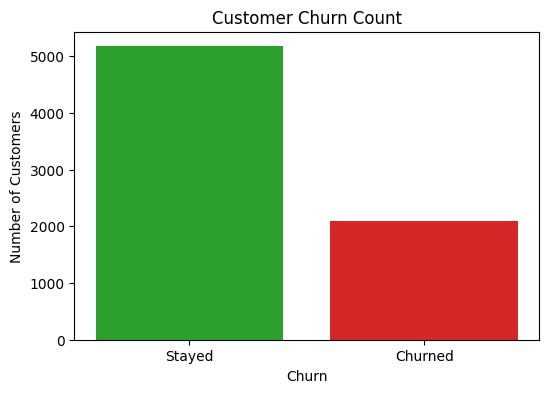

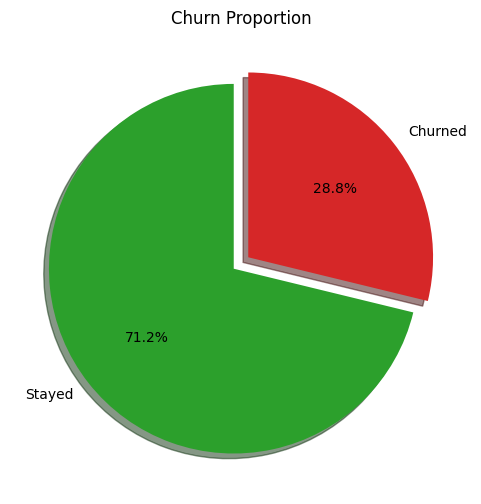

In [6]:
# Compute churn counts
churn_counts = df['Churn'].value_counts().reindex([False, True])

# 1. Bar chart with matplotlib directly
colors = ['tab:green', 'tab:red']
plt.figure(figsize=(6,4))
plt.bar(['Stayed', 'Churned'], churn_counts, color=colors)
plt.title('Customer Churn Count')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.show()
print()

# 2. Pie chart for proportions
plt.figure(figsize=(6,6))
plt.pie(
    churn_counts,
    labels=['Stayed', 'Churned'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=(0.05, 0.05),
    shadow=True
)
plt.title('Churn Proportion')
plt.show()

Churn count by category values

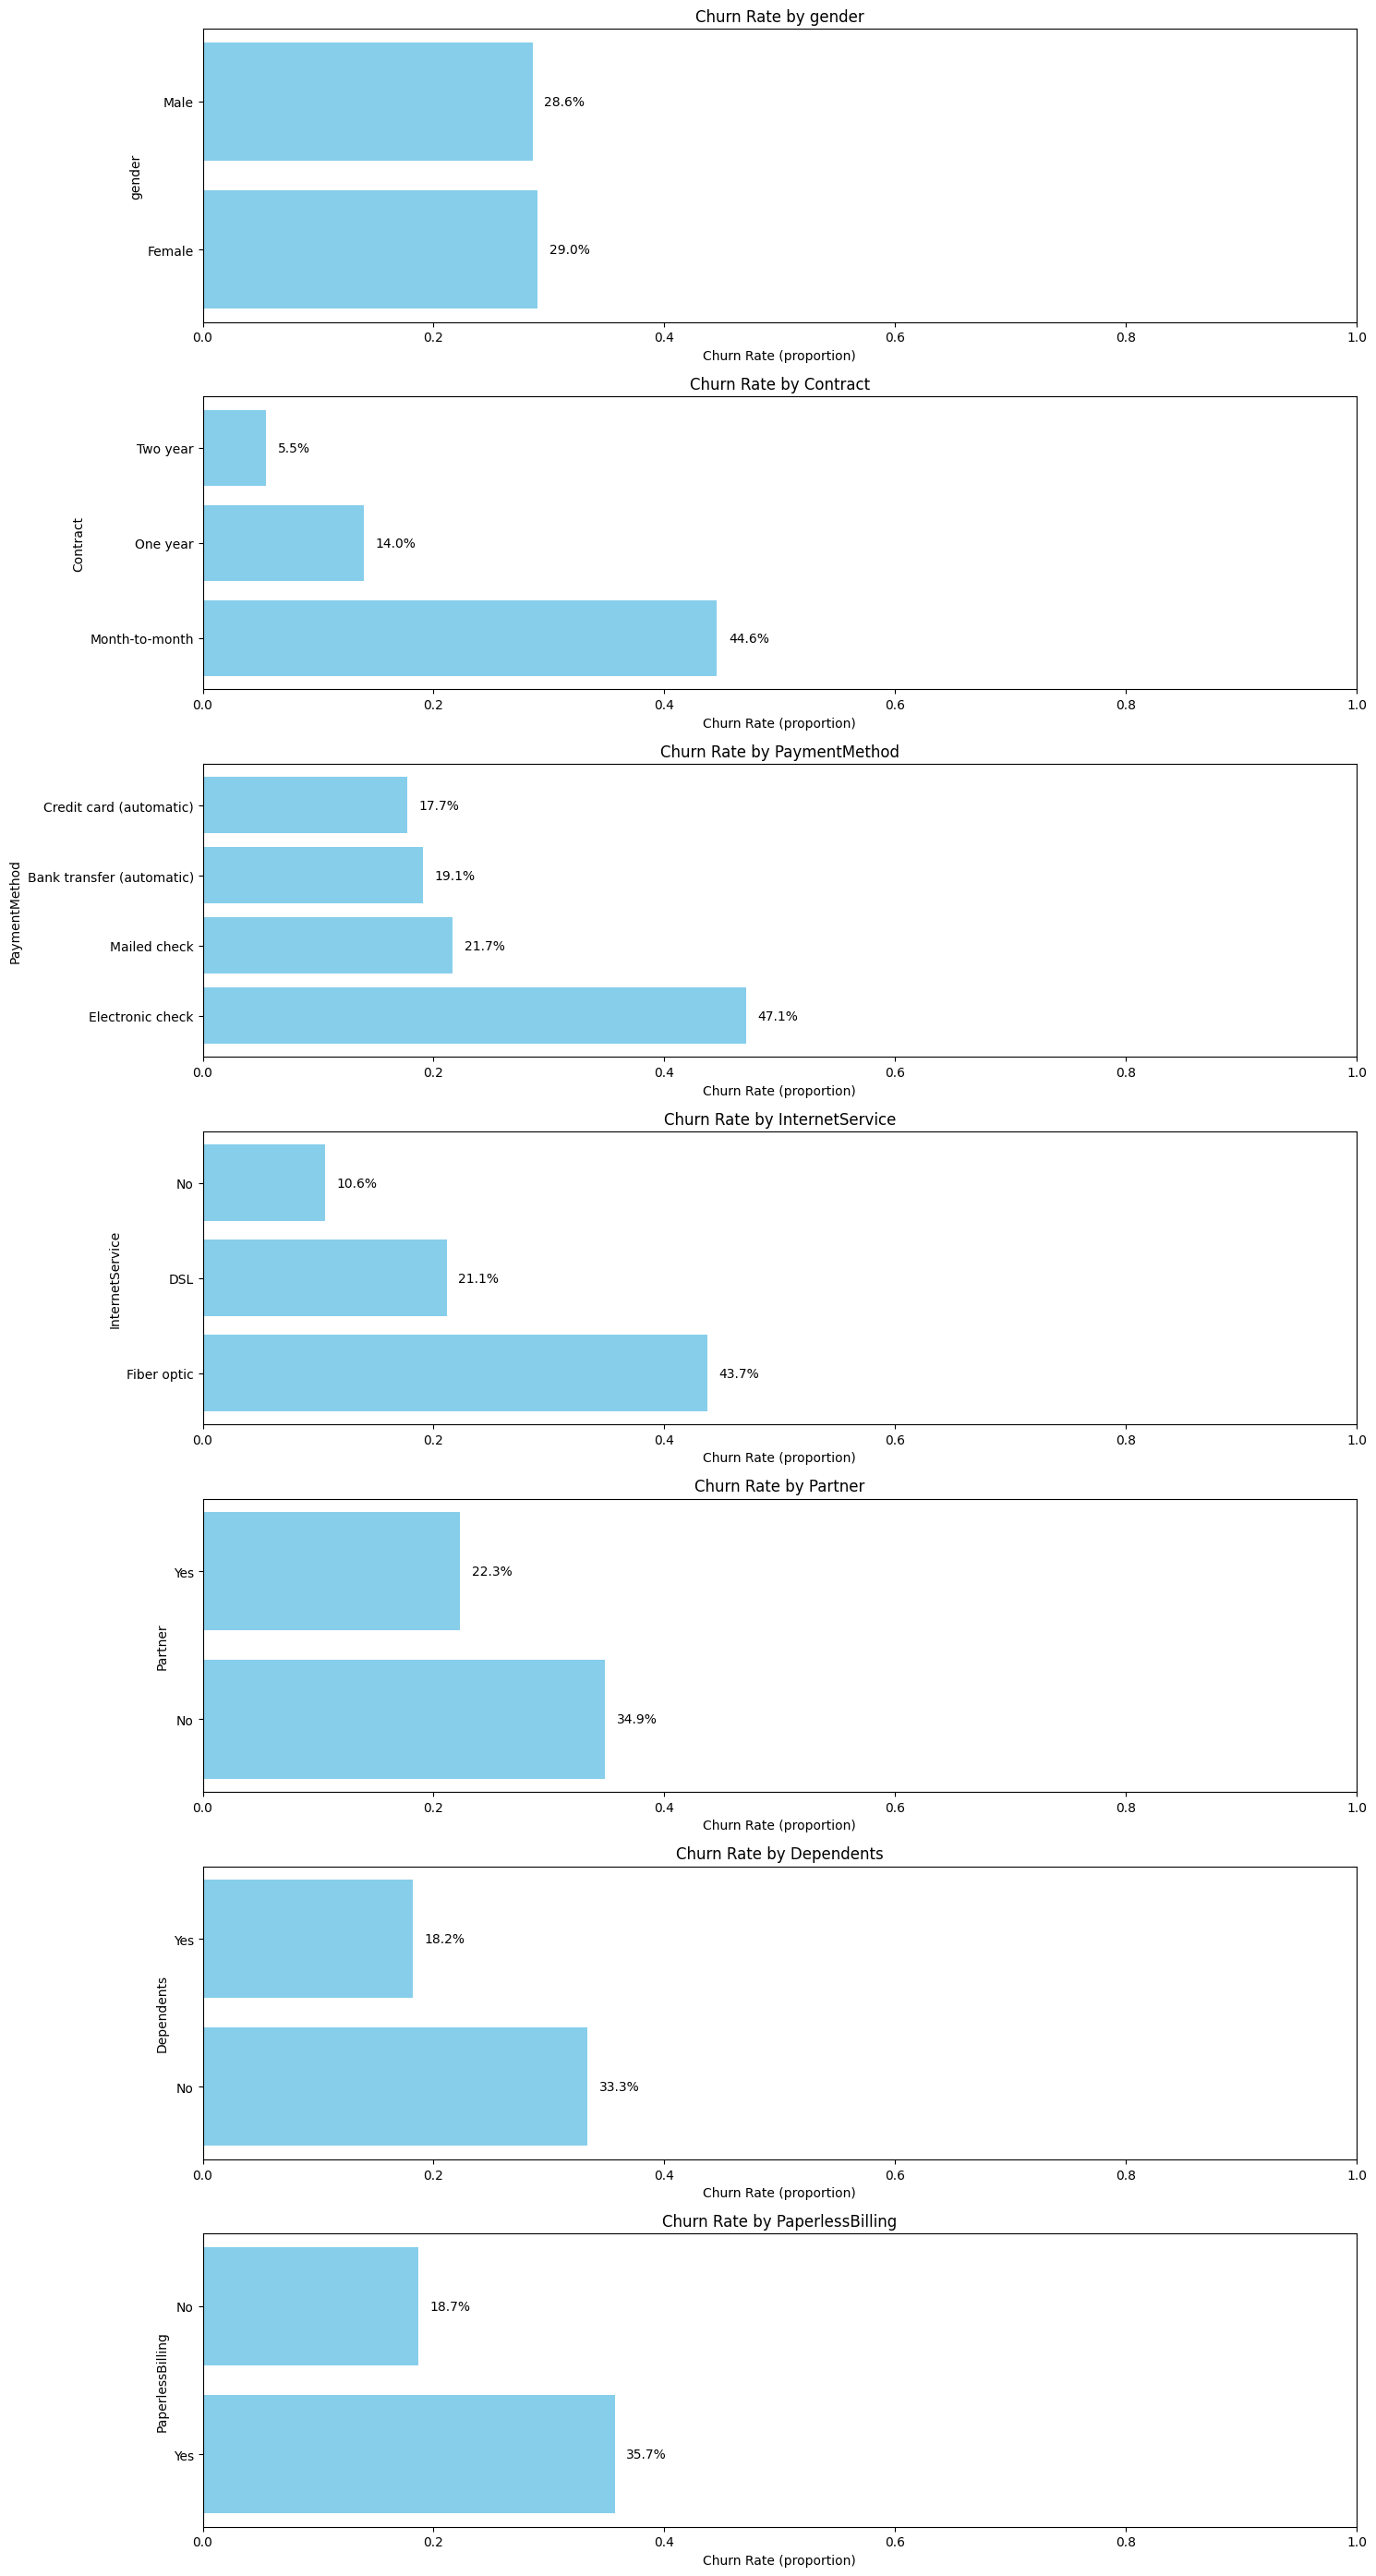

In [7]:
# List of categorical variables to examine
cat_vars = [
    'gender', 'Contract', 'PaymentMethod', 'InternetService',
    'Partner', 'Dependents', 'PaperlessBilling'
]

plt.figure(figsize=(15, len(cat_vars)*4))

for i, col in enumerate(cat_vars, start=1):
    # Compute churn rate per category with observed=True
    rate = df.groupby(col, observed=True)['Churn'].mean().sort_values(ascending=False)

    # If the categories are boolean, map them to string labels
    if rate.index.dtype == 'bool':
        rate.index = rate.index.map({False: 'No', True: 'Yes'})

    ax = plt.subplot(len(cat_vars), 1, i)
    ax.barh(rate.index, rate.values, color='skyblue')
    ax.set_xlabel('Churn Rate (proportion)')
    ax.set_ylabel(col)
    ax.set_xlim(0, 1)
    ax.set_title(f'Churn Rate by {col}')
    for j, v in enumerate(rate.values):
        ax.text(v + 0.01, j, f"{v:.1%}", va='center')

plt.tight_layout()
plt.show()

Churn count by numerical values

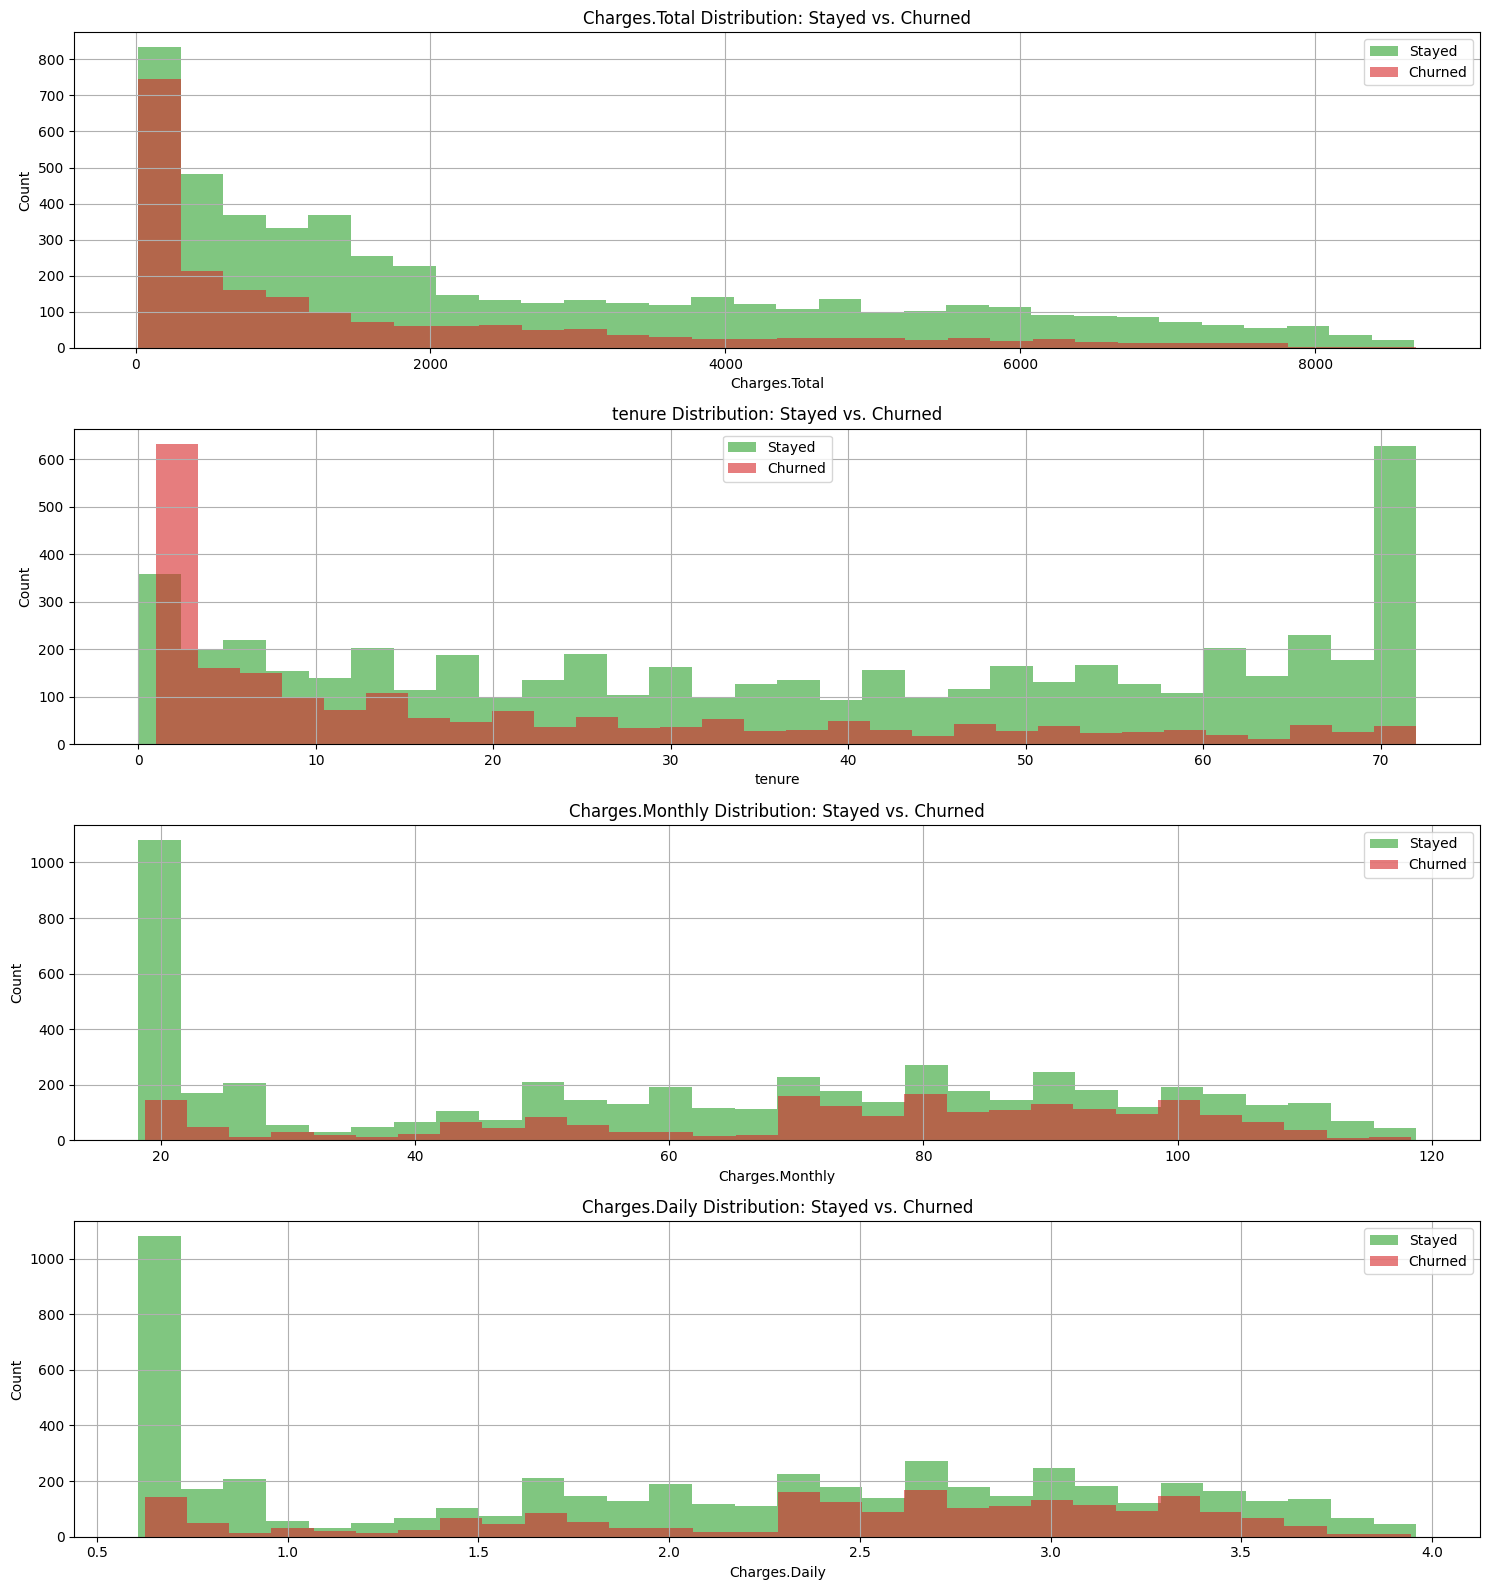

In [8]:
num_vars = ['Charges.Total', 'tenure', 'Charges.Monthly', 'Charges.Daily']
colors = ['tab:green', 'tab:red']   # False→Stayed, True→Churned

plt.figure(figsize=(15, len(num_vars)*4))
for i, col in enumerate(num_vars, 1):
    stayed = df.loc[df['Churn']==False, col].dropna()
    churned = df.loc[df['Churn']==True,  col].dropna()
    bins = 30  # adjust as needed

    ax = plt.subplot(len(num_vars), 1, i)
    ax.hist(stayed,  bins=bins, color=colors[0], alpha=0.6, label='Stayed')
    ax.hist(churned, bins=bins, color=colors[1], alpha=0.6, label='Churned')

    ax.set_title(f'{col} Distribution: Stayed vs. Churned')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


4. Final report

---



# Telecom X Customer Churn Analysis Report

## 1. Introduction  
Customer churn (when subscribers cancel their service) directly impacts revenue and growth. In this analysis, we examine Telecom X’s customer dataset (7,267 records, 22 features) to:  
- Understand which customer segments are most likely to churn  
- Identify numeric and categorical factors associated with churn  
- Provide actionable recommendations to reduce churn

***

## 2. Data Cleaning & Treatment  
1. **Data Loading**  
   -  Loaded raw JSON from GitHub using `pd.read_json`.  
2. **Flatten Nested Structures**  
   -  Expanded `customer`, `phone`, `internet`, and `account` JSON columns into individual DataFrame columns via `pd.json_normalize`.  
3. **Type Conversion**  
   -  Converted numeric fields (`tenure`, `Charges.Monthly`, `Charges.Total`) to `int`/`float`.  
   -  Imputed empty strings in `Charges.Total` as `NaN`.  
4. **Boolean & Categorical Handling**  
   -  Normalized all “Yes”/“No” variations (case-insensitive, trimmed whitespace) into Python booleans.  
   -  Converted high-cardinality and service-state columns (`gender`, `Contract`, `PaymentMethod`, `InternetService`, etc.) to `category` dtype.  
5. **Derived Feature**  
   -  Created `Charges.Daily = Charges.Monthly / 30` to estimate daily spending.

***

## 3. Exploratory Data Analysis  

### 3.1 Churn Overview  
- **Count Chart**: ~25.7% churn rate vs. 74.3% retention (bar and pie charts).  
- Customers on **month-to-month** contracts churn at 44.6%, far above **one-year** (14%) and **two-year** (5.3%).  
- **Payment method** matters: electronic check users churn at 47.1% compared to ~17–22% for other methods.  

### 3.2 Categorical Factors  
*(Horizontal bar charts of churn rate by category)*  
- **Contract**: Month-to-month highest churn (44.6%).  
- **PaymentMethod**: Electronic check highest (47.1%).  
- **InternetService**: Fiber optic users churn at 43.7% vs. 10.6% for no internet.  
- **Partner**: Customers without a partner churn at 36.9% vs. 22.3% with partner.  
- **Dependents**: No dependents churn at 33.3% vs. 18.2% with dependents.  
- **PaperlessBilling**: Users with paperless billing churn at 35.7% vs. 18.7% without.

### 3.3 Numeric Distributions  
*(Overlaid histograms of numeric features by churn status)*  
- **Tenure**: Churners concentrate at low tenure (peak under 12 months); long-tenure customers rarely churn.  
- **Charges.Total**: Churners skew toward lower total spending; high spenders less likely to leave.  
- **Charges.Monthly / Charges.Daily**: Similar patterns—higher monthly/daily spend correlates with retention.

***

## 4. Conclusions & Insights  
- **Short tenure** and **month-to-month contracts** are the strongest churn drivers.  
- **Electronic check** payment and **fiber optic** internet significantly increase churn risk.  
- Customers **without partners or dependents** and those opting for **paperless billing** show elevated churn.  
- **Higher spending** and **longer tenure** are protective factors against churn.

***

## 5. Recommendations  
1. **Contract Incentives**  
   - Offer discounts or perks for customers to transition from month-to-month to annual plans.  
2. **Payment Method Engagement**  
   - Incentivize electronic check users to switch to automated payments (credit card or bank transfer).  
3. **Onboarding & Retention Programs**  
   - Deploy targeted onboarding campaigns for new customers (first 3–6 months).  
   - Provide bundle offers (e.g., device protection, streaming) for fiber optic subscribers.  
4. **Customer Segmentation**  
   - Identify high-risk segments (single, no dependents, paperless billing) for personalized outreach.  
5. **Usage-Based Offers**  
   - Reward high-spending, long-tenure customers with loyalty perks to maintain satisfaction.

***

In [9]:
# Export the cleaned/manipulated DataFrame to CSV

# Without row index in the file:
df.to_csv('telecomx_cleaned.csv', index=False)

print("✅ CSV file saved as 'telecomx_cleaned.csv'")


✅ CSV file saved as 'telecomx_cleaned.csv'
